In [4]:
import pprint
from BCBio.GFF import GFFExaminer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kstest, norm, ttest_ind, mannwhitneyu

In [5]:
ggf_file = "hg38-genes.gff"
examiner = GFFExaminer()
in_handle = open(ggf_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('chr1',): 2065,
            ('chr10',): 730,
            ('chr11',): 1317,
            ('chr12',): 1040,
            ('chr13',): 322,
            ('chr14',): 617,
            ('chr15',): 602,
            ('chr16',): 857,
            ('chr17',): 1185,
            ('chr18',): 267,
            ('chr19',): 1476,
            ('chr2',): 1250,
            ('chr20',): 548,
            ('chr21',): 221,
            ('chr22',): 446,
            ('chr3',): 1082,
            ('chr4',): 756,
            ('chr5',): 893,
            ('chr6',): 1052,
            ('chr7',): 931,
            ('chr8',): 703,
            ('chr9',): 775,
            ('chrM',): 13,
            ('chrX',): 864,
            ('chrY',): 45},
 'gff_source': {('ENSEMBL',): 13, ('HAVANA',): 20044},
 'gff_source_type': {('ENSEMBL', 'gene'): 13, ('HAVANA', 'gene'): 20044},
 'gff_type': {('gene',): 20057}}


In [6]:
def load_gff(file_path):
  """
  Reads a GFF file and extracts relevant columns.
  """

  columns = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
  gff_data = pd.read_csv(file_path, sep="\t", comment="#", names=columns)
  return gff_data[gff_data["type"] == "gene"]

In [7]:
gff_data = load_gff(ggf_file)
gff_data.head()

,seqid,source,type,start,end,score,strand,phase,attributes
0,chr1,HAVANA,gene,65419,71585,.,+,.,ID=ENSG00000186092.7;gene_id=ENSG00000186092.7...
1,chr1,HAVANA,gene,450740,451678,.,-,.,ID=ENSG00000284733.2;gene_id=ENSG00000284733.2...
2,chr1,HAVANA,gene,685716,686654,.,-,.,ID=ENSG00000284662.2;gene_id=ENSG00000284662.2...
3,chr1,HAVANA,gene,923923,944575,.,+,.,ID=ENSG00000187634.13;gene_id=ENSG00000187634....
4,chr1,HAVANA,gene,944203,959309,.,-,.,ID=ENSG00000188976.11;gene_id=ENSG00000188976....


In [8]:
def classify_genes(data, distance_threshold=1000):
  """
  Classify genes as 'clustered' or 'individual' based on proximity to the next gene.
  Genes are grouped by chromosome and strand.
  """

  # initialize all genes as individual by default
  data["classification"] = "individual"

  for (seqid, strand), group in data.groupby(["seqid", "strand"]):
    # print(f"Processing group: seqid={seqid}, strand={strand}")

    # sorting genes by start position
    sorted_genes = group.sort_values("start")

    # calculate distance using end of one gene and start of the next gene
    distances = sorted_genes["start"].iloc[1:].values - sorted_genes["end"].iloc[:-1].values - 1

    # infinity for the last gene
    distances = np.append(distances, np.inf)

    # indices of genes within the distance threshold
    clustered_indices = np.where(distances <= distance_threshold)[0]

    # current and the next gene as marked as clustered
    for idx in clustered_indices:
        sorted_genes.iloc[idx, sorted_genes.columns.get_loc("classification")] = "clustered"
        if idx + 1 < len(sorted_genes):
            sorted_genes.iloc[idx + 1, sorted_genes.columns.get_loc("classification")] = "clustered"

    # update the main dataframe
    data.loc[sorted_genes.index, "classification"] = sorted_genes["classification"]

  return data

In [9]:
gff_data["classification"] = "individual"
classify_genes(gff_data)

,seqid,source,type,start,end,score,strand,phase,attributes,classification
0,chr1,HAVANA,gene,65419,71585,.,+,.,ID=ENSG00000186092.7;gene_id=ENSG00000186092.7...,individual
1,chr1,HAVANA,gene,450740,451678,.,-,.,ID=ENSG00000284733.2;gene_id=ENSG00000284733.2...,individual
2,chr1,HAVANA,gene,685716,686654,.,-,.,ID=ENSG00000284662.2;gene_id=ENSG00000284662.2...,individual
3,chr1,HAVANA,gene,923923,944575,.,+,.,ID=ENSG00000187634.13;gene_id=ENSG00000187634....,individual
4,chr1,HAVANA,gene,944203,959309,.,-,.,ID=ENSG00000188976.11;gene_id=ENSG00000188976....,individual
...,...,...,...,...,...,...,...,...,...,...
20052,chrY,HAVANA,gene,24607560,24639207,.,+,.,ID=ENSG00000183795.8;gene_id=ENSG00000183795.8...,individual
20053,chrY,HAVANA,gene,24763069,24813492,.,-,.,ID=ENSG00000187191.16;gene_id=ENSG00000187191....,individual
20054,chrY,HAVANA,gene,24833843,24907040,.,+,.,ID=ENSG00000205916.12;gene_id=ENSG00000205916....,individual
20055,chrY,HAVANA,gene,25030901,25062548,.,-,.,ID=ENSG00000185894.8;gene_id=ENSG00000185894.8...,individual


In [10]:
gff_data['classification'].unique()

array(['individual', 'clustered'], dtype=object)

In [11]:
gff_data["length"] = gff_data["end"] - gff_data["start"] + 1

In [12]:
gff_data.head()

,seqid,source,type,start,end,score,strand,phase,attributes,classification,length
0,chr1,HAVANA,gene,65419,71585,.,+,.,ID=ENSG00000186092.7;gene_id=ENSG00000186092.7...,individual,6167
1,chr1,HAVANA,gene,450740,451678,.,-,.,ID=ENSG00000284733.2;gene_id=ENSG00000284733.2...,individual,939
2,chr1,HAVANA,gene,685716,686654,.,-,.,ID=ENSG00000284662.2;gene_id=ENSG00000284662.2...,individual,939
3,chr1,HAVANA,gene,923923,944575,.,+,.,ID=ENSG00000187634.13;gene_id=ENSG00000187634....,individual,20653
4,chr1,HAVANA,gene,944203,959309,.,-,.,ID=ENSG00000188976.11;gene_id=ENSG00000188976....,individual,15107


In [13]:
def compare_gene_lengths(df):
  """
  Compares lengths of clustered and individual genes.
  """

  clustered_lengths = df[df["classification"] == "clustered"]["length"]
  individual_lengths = df[df["classification"] == "individual"]["length"]

  # Plot the distributions
  sns.boxplot(x="classification", y="length", data=df)
  plt.title("Gene Lengths: Clustered vs Individual")
  plt.ylabel("Gene Length")
  plt.show()

  median_clustered = clustered_lengths.median()
  median_individual = individual_lengths.median()
  print(f"Median length of clustered genes: {median_clustered}")
  print(f"Median length of individual genes: {median_individual}")

  u_stat, p_value = mannwhitneyu(clustered_lengths, individual_lengths)
  return u_stat, p_value

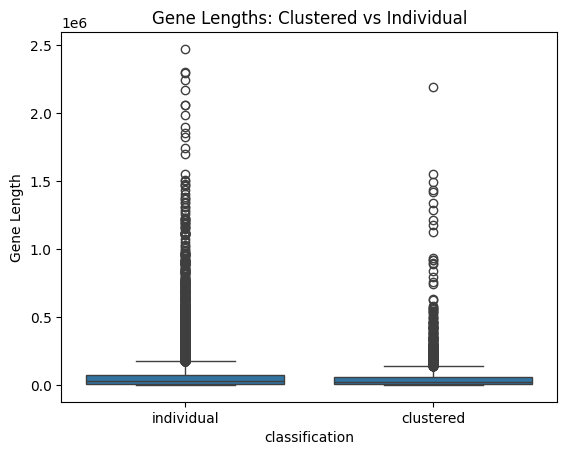

Median length of clustered genes: 22682.0
Median length of individual genes: 28573.0
Mann-Whitney U: 26959376.5
p-value: 7.497147683213215e-15


In [14]:
u_stat, p_value = compare_gene_lengths(gff_data)
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

In [41]:
def calculate_distance(gene1, gene2):
  """
  Calculates the distance between two genes.
  """
  # If overlapping, distance is 0
  if gene1["end"] >= gene2["start"] and gene2["end"] >= gene1["start"]:
      return 0

  return max(gene2["start"] - gene1["end"], gene1["start"] - gene2["end"])

def find_n_closest_genes(gff_df, target_gene, N):
  """
  Finds the N closest genes to the target gene.
  """

  # same chromosome
  same_chr = gff_df[gff_df["seqid"] == target_gene["seqid"]].copy()

  # calculate distances
  same_chr.loc[:, "distance"] = [calculate_distance(target_gene, row) for _, row in same_chr.iterrows()]

  # exclude the target gene
  same_chr = same_chr[~((same_chr["start"] == target_gene["start"]) & (same_chr["end"] == target_gene["end"]))]

  # Sort by distance and select N closest genes
  closest_genes = same_chr.sort_values("distance").head(N)

  return closest_genes

In [45]:
chr = input("Enter chromosome for target gene: ")
start = int(input("Enter start for target gene: "))
end = int(input("Enter end for target gene: "))
target_gene = {"seqid": chr, "start": start, "end": end}

N = int(input("Enter the number of closest genes to find (N): "))
closest_genes = find_n_closest_genes(gff_data, target_gene, N)

# Display the result
print(closest_genes[["seqid", "start", "end", "distance"]])

Enter chromosome for target gene: chr1
Enter start for target gene: 923923
Enter end for target gene: 944575
Enter the number of closest genes to find (N): 5
  seqid   start      end  distance
4  chr1  944203   959309         0
5  chr1  960584   965719     16009
6  chr1  966482   975865     21907
7  chr1  975198   982117     30623
8  chr1  998962  1000172     54387
